# Forecast with Cold Start Items

Consider the situation where a set of related new items got introduced into the catalog, one needs to forecast the future values for those items. In such a situation, little to none demand history is available for those items. This scenario is coined as "cold-start problem." 

<img src="BlogImages/amazon_forecast.png">

# Introduction

In this notebook, we walk through the process of generating forecasts for cold start items. Notice that <b>only DeepAR+ supports cold start.</b> At a high level, the flow can be summarized as follows. 

1. We follow the complete process with non-cold start items as in the previous notebooks such as 
 * [4. Getting_started_with_DeepAR+.ipynb](https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/4.%20Getting_started_with_DeepAR%2B.ipynb) or 
 * [6. Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb](https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/6.Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb). 
 
 The major addition is that, *the item meta information for both the cold start and non-cold start items are imported in the system*. 

2. Create another dataset with the cold start items, and create forecasts for those items. Here for simplicity, we only use target time series only dataset, but related time series can be incorporated as well. 


# Table of Contents

* Step 0: [Setting up](#setup)
* Step 1: [Preparing the Datasets](#prepare)
* Step 2: [Importing the Data for Non-Cold Start Items](#import)
 * Step 2a: [Creating a Dataset Group](#create)
 * Step 2b: [Creating a Target Dataset](#target)
 * Step 2c: [Creating a Item Meta Information Dataset](#related)
 * Step 2d: [Update the Dataset Group](#update)
 * Step 2e: [Creating a Target Time Series Dataset Import Job](#targetImport)
 * Step 2f: [Creating a Item Meta Information Dataset Import Job](#relatedImport)
* Step 3: [Create the DeepAR+ Predictor](#algo)
* Step 4: [Create a Forecast for non-Cold Start Items](#forecast)

The above steps complete the model training with the non-Cold Start items. Now we ready to import the cold start items, and generate their forecats. 

* Step 5: [Create a Cold-Start Target Time Series Dataset Import Job](#coldStartImport)
* Step 6: [Create a Forecast for the cold start items](#createColdStart) 
* Step 7: [Querying the Forecasts](#query)
* Step 8: [Exporting the Forecasts](#export)
* Step 9: [Clearning up your Resources](#cleanup)

# Step 0:  First let us setup Amazon Forecast<a class="anchor" id="setup">

This section sets up the permissions and relevant endpoints.

In [1]:
%load_ext autoreload
%autoreload 2  
from util.fcst_utils import *
import warnings
import boto3
import s3fs
import pandas as pd
plt.rcParams['figure.figsize'] = (15.0, 5.0)
warnings.filterwarnings('ignore')

Although, we have set the region to us-west-2 below, you can choose any of the 6 regions that the service is available in.

In [2]:
region = 'us-west-2'
bucket = 'coldstart-demo'
version = 'prod'

In [3]:
session = boto3.Session(region_name='us-west-2') 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [ ]:
role_arn = get_or_create_role_arn()

# Step 1: Preparing the Datasets<a class="anchor" id="prepare">
    
    
Here we use a synthetic dataset based on [electricity]() dataset, which consists of the hourly time series for 370 households (with item id 0 to 369). 

In this hypothetical senario, our goal is to generate forecasts for 4 new customers with item id 370 to 373. 

In [5]:
zipLocalFilePath = "../data/cold-start/test.csv.gz"

In [ ]:
# do `!pip install sh` if you don't have sh 
from sh import gunzip
gunzip(zipLocalFilePath)

In [ ]:
localFilePath = "../data/cold-start/test.csv"

In [6]:
tdf = pd.read_csv(zipLocalFilePath, dtype = object)
tdf.head()

,timestamp,target_value,item_id
0,2014-01-01 01:00:00,2.53807106598985,client_0
1,2014-01-01 01:00:00,23.648648648648624,client_1
2,2014-01-01 01:00:00,0.0,client_2
3,2014-01-01 01:00:00,144.81707317073176,client_3
4,2014-01-01 01:00:00,75.0,client_4


In [7]:
tdf['target_value'] = tdf['target_value'].astype('float')

Let us plot one time series first.

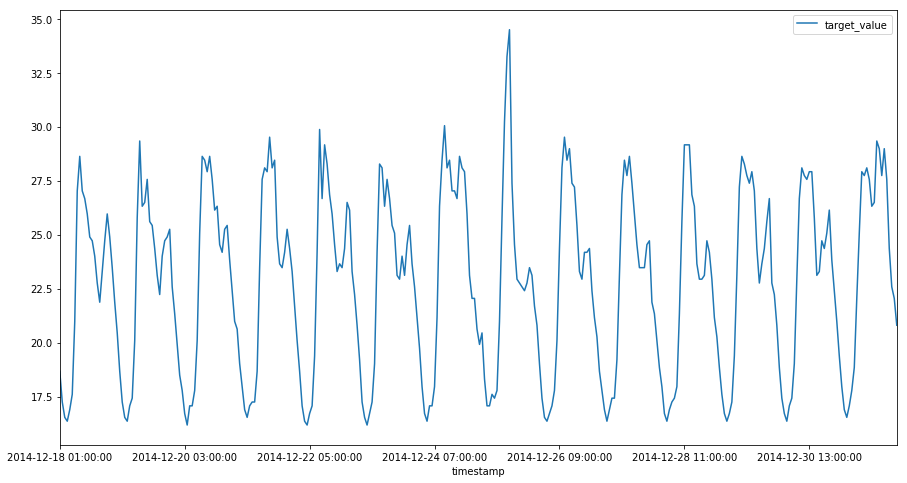

In [8]:
tdf[tdf['item_id'] == 'client_1'][-24*7*2:]\
    .plot(x='timestamp', y='target_value', figsize=(15, 8)); 

Next, we use an item meta information dataset that contains the information for both the non-cold start items (client 0 to 369) and cold start items (client 370 to 373). We call this meta information "type" in this specific case. Only one categorical feature is used in this demo, but in practice one normally has multiple categorical features. 

Note that for cold start items where little to none demand history exists, the algorithm can only "transfer" information from the existing items to the new ones through the meta information. Therefore, having informative and high quality meta data is the key for a good cold-start forecast. 

In [9]:
# this metadata contains the cold start items' metadata as well.
localItemMetaDataFilePath = "../data/cold-start/itemMetaData.csv"
imdf = pd.read_csv(localItemMetaDataFilePath, dtype = object)

imdf.tail()

,item_id,type
368,client_369,D
369,client_370,A
370,client_371,B
371,client_372,C
372,client_373,D


And the following figure shows the histogram of the category "type."

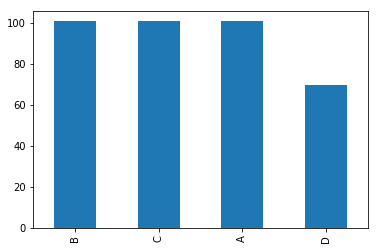

In [10]:
imdf['type'].value_counts().plot(kind='bar');

In [11]:
s3 = session.client('s3')

In [12]:
accountId = boto3.client('sts').get_caller_identity().get('Account')

If you don't have this bucket `amazon-forecast-data`, create it first on S3.

In [13]:
bucketName = "amazon-forecast-data-{0}".format(accountId)# Update the unique-value bit here.
targetTimeseriesDatakey = "cold-start/test.csv"

s3.upload_file(Filename=localFilePath, Bucket = bucketName, Key = f"{targetTimeseriesDatakey}")

In [14]:
itemMetaDatakey = "cold-start/itemMetaData.csv"

s3.upload_file(Filename=localItemMetaDataFilePath, Bucket = bucketName, Key = f"{itemMetaDatakey}")

In [15]:
project = "coldstart_demo"

Below, we specify key input data and forecast parameters

In [16]:
freq = "H"
forecast_horizon = 48
timestamp_format = "yyyy-MM-dd HH:mm:ss"
delimiter = ','

## Step 2a. Creating a Dataset Group<a class="anchor" id="create">
First let's create a dataset group and then update it later to add our datasets.

In [55]:
dataset_group = f"{project}_grp"
dataset_arns = []
create_dataset_group_response = forecast.create_dataset_group(Domain="CUSTOM",
                                                          DatasetGroupName=dataset_group,
                                                          DatasetArns=dataset_arns)

In [56]:
logging.info(f'Creating dataset group {dataset_group}')

In [57]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2b. Creating a Target Dataset<a class="anchor" id="target">
In this example, we will define a target time series. This is a required dataset to use the service.

Below we specify the target time series name af_demo_ts_4.

In [59]:
ts_dataset_name = f"{project}_ts"
print(ts_dataset_name)

coldstart_demo_ts


Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw 
data in the files. We follow the same three attribute format as the above example.

In [60]:
ts_schema_val = [{"AttributeName": "timestamp", "AttributeType": "timestamp"},
                {"AttributeName": "target_value", "AttributeType": "float"},
                {"AttributeName": "item_id", "AttributeType": "string"}]
ts_schema = {"Attributes": ts_schema_val}

In [61]:
logging.info(f'Creating target dataset {ts_dataset_name}')

In [62]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='TARGET_TIME_SERIES',
                               DatasetName=ts_dataset_name,
                               DataFrequency=freq,
                               Schema=ts_schema
                              )

In [63]:
ts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

## Step 2c. Creating ItemMetaData Dataset<a class="anchor" id="related">
In this example, we will define a Item Metadata Dataset.

Specify the related time series name af_demo_rts_4.

In [65]:
item_metadata_dataset_name = f"{project}_meta"
print(item_metadata_dataset_name)

coldstart_demo_meta


Specify the schema of your dataset here. Make sure the order of columns matches the raw data files. We follow the same three column format as the above example.

In [66]:
meta_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "category", "AttributeType": "string"}]
meta_schema = {"Attributes": meta_schema_val}

In [67]:
logging.info(f'Creating related dataset {meta_schema}')

In [68]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='ITEM_METADATA',
                               DatasetName=item_metadata_dataset_name,
                               Schema=meta_schema
                              )

In [69]:
meta_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=meta_dataset_arn)

## Step 2d. Updating the dataset group with the datasets we created<a class="anchor" id="update">
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [ ]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(meta_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2e. Creating a Target Time Series Dataset Import Job<a class="anchor" id="targetImport">

In [73]:
ts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=ts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": f"s3://{bucketName}/{targetTimeseriesDatakey}",
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [74]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [75]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

......


## Step 2f. Creating a Item Meta Data Dataset Import Job<a class="anchor" id="relatedImport">

In [76]:
meta_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=meta_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": f"s3://{bucketName}/{itemMetaDatakey}",
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             })

In [77]:
meta_dataset_import_job_arn=meta_dataset_import_job_response['DatasetImportJobArn']

In [78]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=meta_dataset_import_job_arn))
assert status

.....


# Step 3. Create  Predictor with the datasets<a class="anchor" id="algo">

In [79]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'

In [80]:
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f'{project}_{algorithm.lower()}'

In [81]:
logging.info(f'[{predictor_name_deep_ar}] Creating predictor {predictor_name_deep_ar} ...')

In [82]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [83]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [84]:
status = wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

.........................................................................


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

# Step 4. Creating a Forecast<a class="anchor" id="forecast">

Next we re-train with the full dataset, and create the forecast.

In [86]:
logging.info(f"Done fetching accuracy numbers. Creating forecaster for DeepAR+ ...")

In [87]:
forecast_name_deep_ar = f'{project}_deep_ar_plus_2'

In [88]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [89]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [90]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

.......................................................................


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

# Step 5. Creating a Cold-Start Target Time Series Dataset Import Job<a class="anchor" id="coldStartImport">
    
Now we are ready to generate the forecasts for the cold start problem. Notice that there is a system constraint such that at least 5 rows needs to be present for each item. Therefore, for the item that has less than 5 observations, we fill in with NaNs. In the following example, both Client 370 and 372 have zero observation, i.e., pure cold-start problem, while the other two have 5 target values. 

In [92]:
localColdStartDataFilePath = "../data/cold-start/coldStartTargetData.csv"
# validation logic for at least 5 items
cstdf = pd.read_csv(localColdStartDataFilePath, dtype = object)
cstdf.head(20)

,timestamp,target_value,item_id
0,2014-12-31 20:00:00,NaN,client_370
1,2014-12-31 21:00:00,NaN,client_370
2,2014-12-31 22:00:00,NaN,client_370
3,2014-12-31 23:00:00,NaN,client_370
4,2015-01-01 00:00:00,NaN,client_370
5,2014-12-31 20:00:00,0.14,client_371
6,2014-12-31 21:00:00,0.14,client_371
7,2014-12-31 22:00:00,0.15,client_371
8,2014-12-31 23:00:00,0.18,client_371
9,2015-01-01 00:00:00,0.18,client_371


In [93]:
coldStartTargetTimeseriesDatakey = "cold-start/coldStartTargetData.csv"

In [94]:
s3.upload_file(Filename=localColdStartDataFilePath, 
               Bucket = bucketName, 
               Key = f"{coldStartTargetTimeseriesDatakey}")

In [95]:
ts_cold_start_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group+"_2",
                                                             DatasetArn=ts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": f"s3://{bucketName}/{coldStartTargetTimeseriesDatakey}",
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [96]:
ts_cold_start_dataset_import_job_arn = ts_cold_start_dataset_import_job_response['DatasetImportJobArn']

In [ ]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ts_cold_start_dataset_import_job_arn)

In [98]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_cold_start_dataset_import_job_arn))
assert status

....


# Step 6. Create a ColdStart Item Forecast<a class="anchor" id="createColdStart">
    
    
Now we are ready to create the forecasts for all cold start items.

In [101]:
forecast_name_deep_ar_2 = f'{project}_deep_ar_plus_3'

In [102]:
create_forecast_response_deep_ar_2 = forecast.create_forecast(ForecastName=forecast_name_deep_ar_2,
                                                        PredictorArn=predictor_arn_deep_ar)

In [103]:
forecast_arn_deep_ar_2 = create_forecast_response_deep_ar_2['ForecastArn']

In [104]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar_2))
assert status

.....................................


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar_2)

# Step 7. Querying the ColdStart Item Forecast<a class="anchor" id="query">
    
Now we plot the forecast, where the first vertical line is the forecast start date.

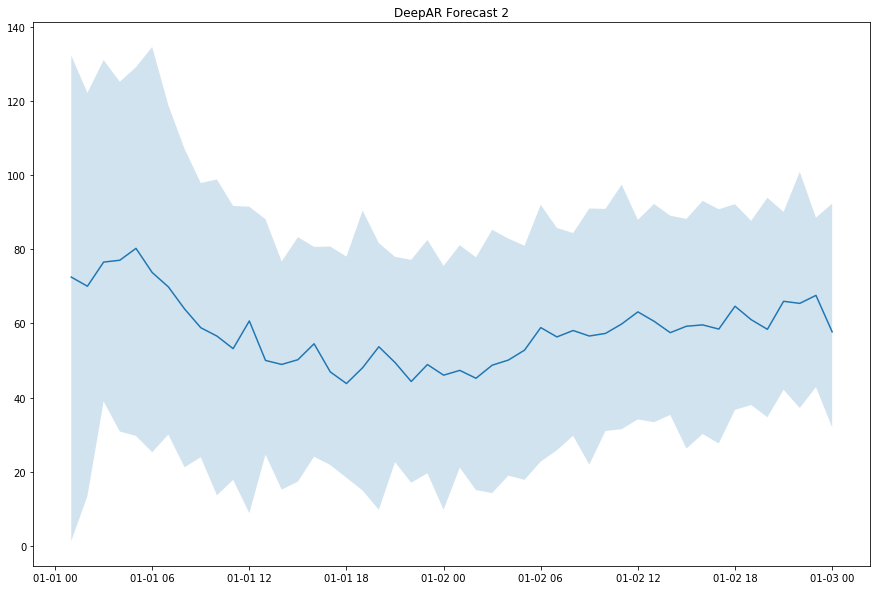

In [130]:
forecast_response_deep_2 = forecast_query.query_forecast(
    ForecastArn=forecast_arn_deep_ar_2,
    Filters={"item_id": "client_370"})


fcst = forecast_response_deep_2['Forecast']['Predictions']
time_stamp = list(map(lambda x: pd.to_datetime(x['Timestamp']), fcst['p10']))
p10_fcst = list(map(lambda x: x['Value'], fcst['p10']))
p50_fcst = list(map(lambda x: x['Value'], fcst['p50']))
p90_fcst = list(map(lambda x: x['Value'], fcst['p90']))

plt.figure(figsize=(15, 10))
plt.plot(time_stamp, p50_fcst)
plt.fill_between(time_stamp, p10_fcst, p90_fcst, alpha=0.2)
plt.title("DeepAR Forecast 2");

# Step 8. Exporting your Forecasts<a class="anchor" id="export">

In [137]:
s3_data_path = f's3://{bucketName}/'

In [138]:
forecast_export_name_deep_ar = f'{project}_cold_start_forecast_export_deep_ar_plus'
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [139]:
create_forecast_export_response_deep_ar = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                                        ForecastArn=forecast_arn_deep_ar_2,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_deep_ar_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

# Step 9. Cleaning up your Resources<a class="anchor" id="cleanup">

Once we have completed the above steps, we can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [ ]:
# Delete forecast export for both algorithms
wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_deep_ar))

In [141]:
# Delete forecast
wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_deep_ar))

In [142]:
# Delete predictor
wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deep_ar))

In [ ]:
# Delete the target time series and related time series dataset import jobs
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))

In [ ]:
# Delete the target time series and related time series datasets
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=rts_dataset_arn))

In [ ]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)